Transfer Learning y fine-tunning --- 0:00 min
===

* Última modificación: Marzo 1, 2022 | YouTube

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Descarga de datos
---

In [2]:
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

path_to_zip = tf.keras.utils.get_file(
    "cats_and_dogs.zip",
    origin=_URL,
    extract=True,
    cache_subdir="/tmp",
)

PATH = os.path.join(
    os.path.dirname(path_to_zip),
    "cats_and_dogs_filtered",
)

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

68616192/68606236 [==============================] - 8s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

Found 1000 files belonging to 2 classes.


Imágenes de ejemplo
---

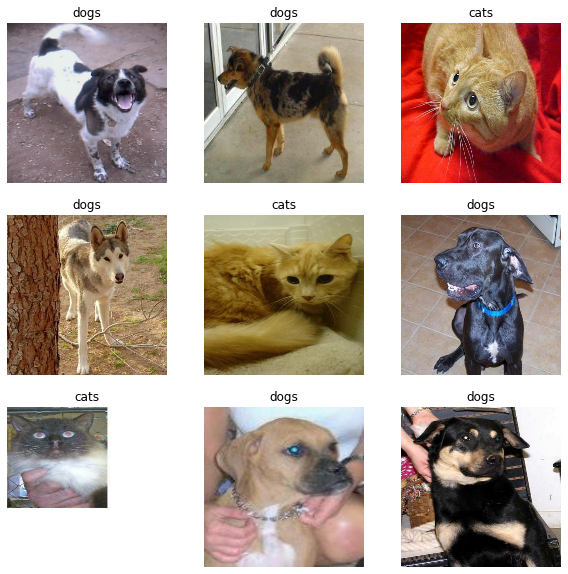

In [4]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Creación de un dataset de validación
---

In [6]:
#
# Obtiene la cantidad de batches para validación
#
val_batches = tf.data.experimental.cardinality(validation_dataset)

#
# Toma el 20% para validación y el resto para test
#
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


Configuración para desempeño
---

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data augmentation
---

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

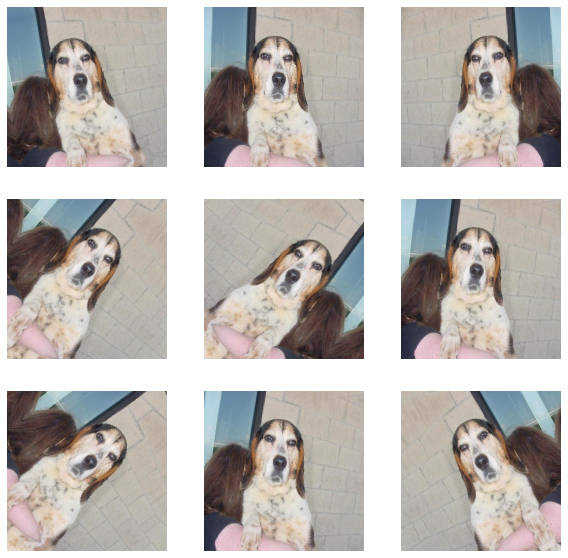

In [9]:
#
# Ejemplos de las imagenes aumentadas
#
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

Escalamiento del valor de los pixels
---

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Nota** Es posible usar tf.keras.Rescaling

```python
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
````

Creación del modelo base
---

![assets/mobilenet-1.png](assets/mobilenet-1.png)

![assets/mobilenet-2.png](assets/mobilenet-2.png)

![assets/imagenet.png](assets/imagenet.png)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    # -----------------------------------------------------------------------------------
    # Indica si se incluye o no una capa completamente conectada en el top de la nn.
    include_top=False,
    # -----------------------------------------------------------------------------------
    # Pesos pre-entrenados con imagenet
    weights="imagenet",
)

9420800/9406464 [==============================] - 1s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Extracción de características
---

In [14]:
#
# El modelo se hace no entrenable (se congelan los pesos)
#
base_model.trainable = False

In [16]:
#
# Arquitectura del modelo
#
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Adición de un cabezal de clasificación
---

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [19]:
#
# Encadenamiento de capas
#
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compilación del modelo
---

In [20]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Entrenamiento del modelo
---

In [21]:
#
# error antes de entrenar
#
loss0, accuracy0 = model.evaluate(validation_dataset)

21/21 [==============================] - 5s 193ms/step - loss: 0.8699 - accuracy: 0.4090


In [23]:
initial_epochs = 10

history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
)

Epoch 1/10
63/63 [==============================] - 22s 351ms/step - loss: 0.2048 - accuracy: 0.9085 - val_loss: 0.1319 - val_accuracy: 0.9522
Epoch 2/10
63/63 [==============================] - 21s 335ms/step - loss: 0.1899 - accuracy: 0.9165 - val_loss: 0.1200 - val_accuracy: 0.9583
Epoch 3/10
63/63 [==============================] - 20s 323ms/step - loss: 0.1807 - accuracy: 0.9290 - val_loss: 0.1178 - val_accuracy: 0.9630
Epoch 4/10
63/63 [==============================] - 21s 330ms/step - loss: 0.1894 - accuracy: 0.9160 - val_loss: 0.1038 - val_accuracy: 0.9691
Epoch 5/10
63/63 [==============================] - 19s 297ms/step - loss: 0.1890 - accuracy: 0.9150 - val_loss: 0.0975 - val_accuracy: 0.9753
Epoch 6/10
63/63 [==============================] - 19s 302ms/step - loss: 0.1731 - accuracy: 0.9295 - val_loss: 0.1035 - val_accuracy: 0.9660
Epoch 7/10
63/63 [==============================] - 23s 357ms/step - loss: 0.1779 - accuracy: 0.9225 - val_loss: 0.0913 - val_accuracy: 0.9738

Curvas de aprendizaje
---

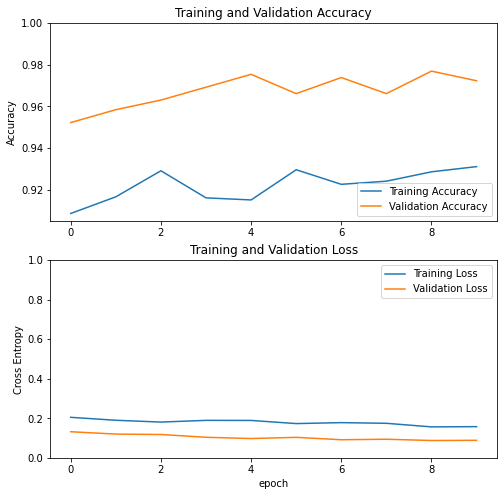

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

Afinamiento
---

In [25]:
base_model.trainable = True

In [26]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [28]:
len(model.trainable_variables)

56

In [29]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/20
63/63 [==============================] - 16s 254ms/step - loss: 0.1518 - accuracy: 0.9400 - val_loss: 0.0841 - val_accuracy: 0.9753
Epoch 11/20
63/63 [==============================] - 16s 260ms/step - loss: 0.1652 - accuracy: 0.9300 - val_loss: 0.0821 - val_accuracy: 0.9738
Epoch 12/20
63/63 [==============================] - 20s 322ms/step - loss: 0.1539 - accuracy: 0.9350 - val_loss: 0.0826 - val_accuracy: 0.9738
Epoch 13/20
63/63 [==============================] - 17s 276ms/step - loss: 0.1516 - accuracy: 0.9385 - val_loss: 0.0788 - val_accuracy: 0.9753
Epoch 14/20
63/63 [==============================] - 18s 283ms/step - loss: 0.1444 - accuracy: 0.9385 - val_loss: 0.0701 - val_accuracy: 0.9815
Epoch 15/20
63/63 [==============================] - 17s 276ms/step - loss: 0.1396 - accuracy: 0.9405 - val_loss: 0.0695 - val_accuracy: 0.9799
Epoch 16/20
63/63 [==============================] - 17s 269ms/step - loss: 0.1412 - accuracy: 0.9325 - val_loss: 0.0727 - val_accuracy:

In [30]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

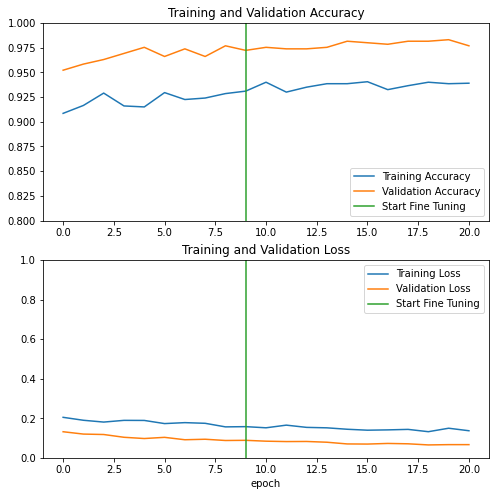

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot(
    [initial_epochs - 1, initial_epochs - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

Evaluación y pronóstico
----

In [32]:
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy :", accuracy)

5/5 [==============================] - 1s 197ms/step - loss: 0.0668 - accuracy: 0.9750
Test accuracy : 0.9750000238418579


Predictions:
 [1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0]
Labels:
 [1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0]


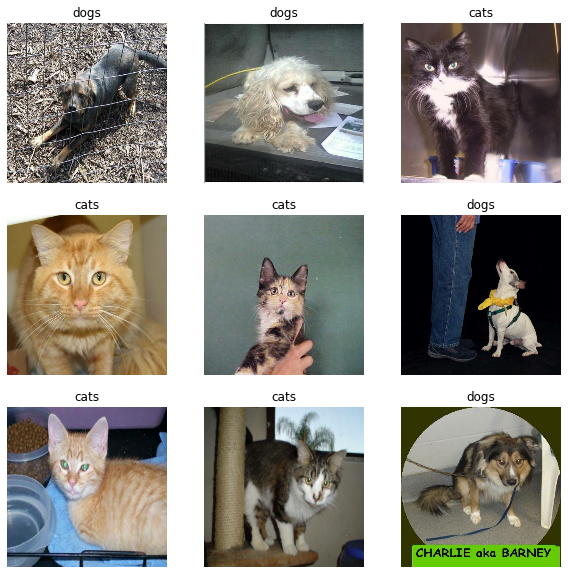

In [33]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")